In [1]:
from pca_items.intrinsic_dimension import IntrinsicDimensionRMT as ID
from pca_items.noise_estimation import MultipleRegressionClassicNoiseEstimator as NE

In [2]:
from visuals import WAVELENGTHS
from pca_helper import *

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import pickle

In [4]:
# grab the pixels of rock, rooftops, and parking lots

In [5]:
parking_lot_dict = pickle.load(open("outliers/parking_lot_items.pickle", 'rb'))
roof_top_dict = pickle.load(open("outliers/roof_top_items.pickle", 'rb'))
rock_dict = pickle.load(open("outliers/rock_items.pickle", 'rb'))

In [6]:
# preform the ID anaysis on the surface types

In [7]:
# multithread the above
import concurrent

def thread_id(s):
    i, series = s[0], s[1]
    print("Starting Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print(f"Series: {i+1} ID: {_id['intrinsic_dimension']}")
    return (i, _id)
    
def thread_series(series_dict):
    id_series = []
    with concurrent.futures.ThreadPoolExecutor() as executer:
        series = [(i, s) for i, s in enumerate(series_dict)]

        results = executer.map(thread_id, series)

        for result in results:
            id_series.append(result)
            
        s = sorted(id_series, key=lambda x: x[0])
        r = [j for i,j in s]
        return r


In [19]:
# import Kerry's noise matrix
# noise = open("SHIFT_noise_M_allbands.txt", "rb").read()
# noise = str(noise).replace("b","").replace("'", "")
# noise = np.array([float(i) for i in str(noise).split(",")])
noise = np.genfromtxt('RMT_debugging_N.csv', delimiter=',')
corrected_noise = np.array([noise[i][i] for i in range(len(noise))])

In [24]:
cond_1_2 = ((wl > 1760) & (wl < 1840))
cond_2_2 = ((wl > 1480) & (wl < 1760))
cond_3_2 = ((wl > 1930) & (wl < 2450))
cond_4_2 = (wl < 1280)
indicies = np.where(cond_1_2 | cond_2_2 | cond_3_2 | cond_4_2)

In [18]:
band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)

cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)
corrected_noise = np.delete(noise, indicies)

IndexError: index 414 is out of bounds for axis 0 with size 356

In [25]:
"""   Parking Lots   """

parking_lot_reflectances = {}
for date in list(parking_lot_dict.keys()):
    valid_pixels = [parking_lot_dict[date]['pixels'][p] for p in range(len(parking_lot_dict[date]['pixels'])) if p not in parking_lot_dict[date]['outliers']]
    parking_lot_reflectances[date] = valid_pixels

In [26]:
# create the respective time series for parking lots

num_dates = len(parking_lot_dict.keys())
parking_lot_dates = [create_raw_time_series(parking_lot_reflectances, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [37]:
parking_lot_series = []
remove_bands = True

for dates, mean_freq in parking_lot_dates:
    master = None
    for d in dates:
        ds = parking_lot_dict[d]['pixels']
        if remove_bands:
                # ds = remove_bands_f(ds) 
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    parking_lot_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [38]:
# run the ID 
# TODO: MULTITHREAD THIS STEP!!!!!!!
parking_lot_id = []
for i, series in enumerate(parking_lot_series):
    print("Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    parking_lot_id.append(_id)

Series:  1
ID:  62
Series:  2


/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


ID:  102
Series:  3
ID:  108
Series:  4
ID:  138
Series:  5
ID:  147
Series:  6
ID:  167
Series:  7
ID:  182
Series:  8
ID:  204
Series:  9
ID:  212
Series:  10
ID:  229
Series:  11
ID:  241
Series:  12
ID:  247
Series:  13
ID:  255


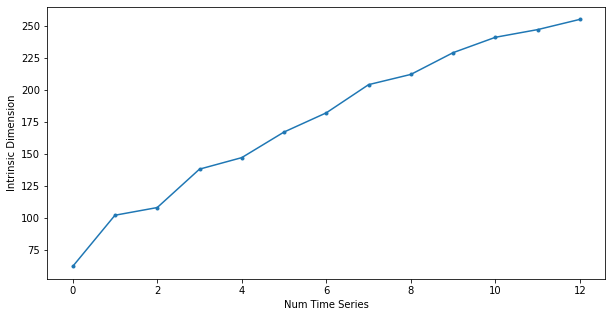

In [39]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
# plt.ylim([0, 140])
plt.plot([i["intrinsic_dimension"] for i in parking_lot_id], marker=".");

In [41]:
nan_inds = []
for i in range(parking_lot_series[-1]['data'].shape[0]):
    if -9999 in list(parking_lot_series[-1]['data'][i]):
        nan_inds.append(i)
nan_inds

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 65,
 74,
 82,
 90,
 96,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,


In [116]:
parking_lot_id_2 = []
for i, series in enumerate(parking_lot_series[:9]):
    print("Series: ", i+1)
    this_mat = np.delete(np.array(series['data']), nan_inds, axis=0)

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    parking_lot_id_2.append(_id)

Series:  1
ID:  22
Series:  2
ID:  43
Series:  3
ID:  53
Series:  4
ID:  67
Series:  5
ID:  74
Series:  6
ID:  85
Series:  7
ID:  86
Series:  8
ID:  103
Series:  9
ID:  104


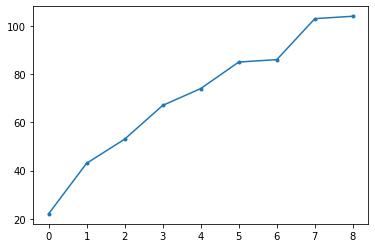

In [117]:
plt.plot([i["intrinsic_dimension"] for i in parking_lot_id_2], marker=".");

In [66]:
"""   Roof Tops   """

roof_top_reflectances = {}
for date in list(roof_top_dict.keys()):
    valid_pixels = [roof_top_dict[date]['pixels'][p] for p in range(len(roof_top_dict[date]['pixels'])) if p not in roof_top_dict[date]['outliers']]
    roof_top_reflectances[date] = valid_pixels

In [67]:
# create the respective time series for parking lots

num_dates = len(roof_top_reflectances.keys())
roof_top_dates = [create_raw_time_series(roof_top_reflectances, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brodrick/miniconda/envs/emit/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
roof_top_series = []
remove_bands = True

for dates, mean_freq in roof_top_dates:
    master = None
    for d in dates:
        ds = roof_top_dict[d]['pixels']
        if remove_bands:
                # ds = remove_bands_f(ds)
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    roof_top_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [39]:
roof_top_id = thread_series(roof_top_series)

Starting Series:  1
Starting Series:  2
Starting Series:  3
Starting Series:  4
Starting Series:  5
Starting Series:  6
Starting Series:  7
Starting Series:  8
Starting Series:  9
Starting Series:  10
Starting Series:  11
Starting Series: Starting Series:  13
 12
Series: 1 ID: 335


/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


Series: 2 ID: 657
Series: 3 ID: 951
Series: 4 ID: 1112
Series: 5 ID: 1358
Series: 6 ID: 1486
Series: 7 ID: 1657
Series: 8 ID: 1778
Series: 9 ID: 1805
Series: 10 ID: 1955
Series: 11 ID: 2014
Series: 12 ID: 2086
Series: 13 ID: 2152


In [ ]:
roof_top_id = [335, 657, 951, 1112, 1358, 1486, 1657, 1778, 1805, 1955, 2014, 2086, 2152]

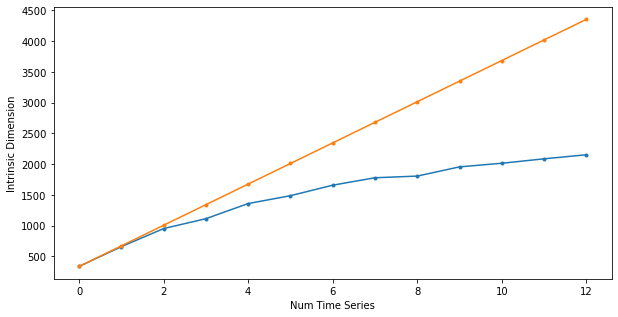

In [77]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in roof_top_id_2], marker=".");
plt.plot([d['data'].shape[1] for d in roof_top_series], marker='.');

Starting Series:  1
Starting Series:  2
Starting Series:  3
Starting Series:  4
Starting Series:  5
Starting Series:  6
Starting Series:  7
Starting Series:  8
Starting Series:  9
Starting Series:  10
Starting Series:  11
Starting Series:  12
Starting Series:  13
Series: 1 ID: 180
Series: 2 ID: 241
Series: 3 ID: 244
Series: 4 ID: 324
Series: 5 ID: 288
Series: 6 ID: 275
Series: 7 ID: 336
Series: 8 ID: 366
Series: 9 ID: 328
Series: 10 ID: 365
Series: 11 ID: 371
Series: 12 ID: 458
Series: 13 ID: 434


TypeError: tuple indices must be integers or slices, not str

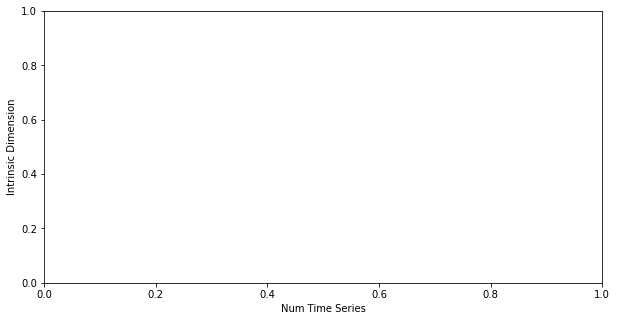

In [65]:
# test on a random subset
num_subset = 200
indicies = np.unique([np.random.randint(0, roof_top_series[0]['data'].shape[0]) for i in range(num_subset)])
data = [d['data'][indicies] for d in roof_top_series]
data_dict = [{'data':d} for d in data]
mini_roof_top_id = thread_series(data_dict)

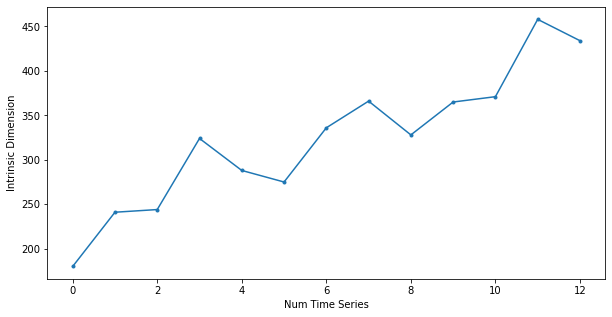

In [66]:
s = sorted(mini_roof_top_id, key=lambda x: x[0])
r = [j for i,j in s]
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in r], marker=".");

In [142]:
nan_inds = []
for i in range(roof_top_series[-1]['data'].shape[0]):
    if -9999 in list(roof_top_series[-1]['data'][i]):
        nan_inds.append(i)
nan_inds

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [143]:
roof_top_id_2 = []
for i, series in enumerate(roof_top_series[:9]):
    print("Series: ", i+1)
    this_mat = np.delete(np.array(series['data']), nan_inds, axis=0)

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    roof_top_id_2.append(_id)

Series:  1
ID:  34
Series:  2
ID:  65
Series:  3
ID:  74
Series:  4
ID:  85
Series:  5
ID:  96
Series:  6
ID:  109
Series:  7
ID:  112
Series:  8
ID:  120
Series:  9
ID:  126


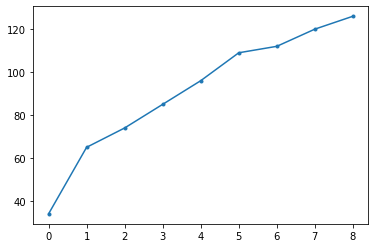

In [144]:
plt.plot([i["intrinsic_dimension"] for i in roof_top_id_2], marker=".");

In [69]:
# bootstrap sample the pixels from the roof tops

In [70]:
"""   Rocks   """

rock_reflectances = {}
for date in list(rock_dict.keys()):
    valid_pixels = [rock_dict[date]['pixels'][p] for p in range(len(rock_dict[date]['pixels'])) if p not in rock_dict[date]['outliers']]
    rock_reflectances[date] = valid_pixels

In [71]:
# create the respective time series for parking lots

num_dates = len(rock_dict.keys())
rock_dates = [create_raw_time_series(rock_reflectances, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [162]:
rock_series = []
remove_bands = True

for dates, mean_freq in rock_dates:
    master = None
    for d in dates:
        ds = rock_dict[d]['pixels']
        if remove_bands:
                # ds = remove_bands_f(ds)
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    rock_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [ ]:
# run the ID 
rock_id = []
for i, series in enumerate(rock_series):
    print("Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    rock_id.append(_id)

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in rock_id], marker=".");

In [146]:
nan_inds = []
for i in range(rock_series[-1]['data'].shape[0]):
    if -9999 in list(rock_series[-1]['data'][i]):
        nan_inds.append(i)
nan_inds

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [160]:
temp_noise = open("/home/makiper/Notebooks/SHIFT_noise_M_allbands.txt", "rb").read()
temp_noise = str(temp_noise).replace("b","").replace("'", "")
temp_noise = np.array([float(i) for i in str(temp_noise).split(",")])

band_ranges = [(1340, 1460), (1800, 2050), 2450, 400]
wl = np.array(WAVELENGTHS)

cond_1 = ((wl > band_ranges[0][0]) & (wl < band_ranges[0][1]))
cond_2 = ((wl > band_ranges[1][0]) & (wl < band_ranges[1][1]))
cond_3 = (wl > band_ranges[2])
cond_4 = (wl < band_ranges[3])
temp_indicies = np.where(cond_1 | cond_2 | cond_3 | cond_4)
temp_corrected_noise = np.delete(temp_noise, temp_indicies)

rock_id_2 = []
for i, series in enumerate(rock_series[:12]):
    print("Series: ", i+1)
    this_mat = np.delete(np.array(series['data']), nan_inds, axis=0)

    this_noise = temp_corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, temp_corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    rock_id_2.append(_id)

Series:  1
ID:  335
Series:  2
ID:  665
Series:  3
ID:  876
Series:  4
ID:  1044
Series:  5
ID:  1156
Series:  6
ID:  1269
Series:  7
ID:  1347
Series:  8
ID:  1431
Series:  9
ID:  1479
Series:  10
ID:  1533
Series:  11
ID:  1570
Series:  12
ID:  1603


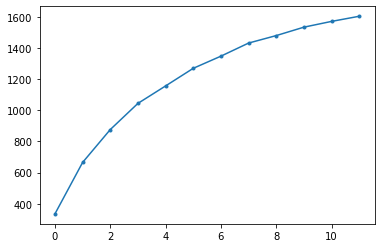

In [161]:
plt.plot([i["intrinsic_dimension"] for i in rock_id_2], marker=".");

In [163]:

rock_id_2 = []
for i, series in enumerate(rock_series[:12]):
    print("Series: ", i+1)
    this_mat = np.delete(np.array(series['data']), nan_inds, axis=0)

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    rock_id_2.append(_id)

Series:  1
ID:  73
Series:  2
ID:  122
Series:  3
ID:  156
Series:  4
ID:  187
Series:  5
ID:  216
Series:  6
ID:  241
Series:  7
ID:  258
Series:  8
ID:  274
Series:  9
ID:  290
Series:  10
ID:  303
Series:  11
ID:  316
Series:  12
ID:  335


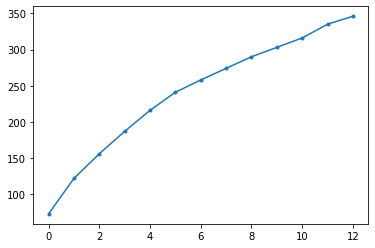

In [170]:
plt.plot([i["intrinsic_dimension"] for i in rock_id_2], marker=".");

In [36]:
#### Try with Phil's veg data

In [8]:
import pandas as pd

veg_data = pd.read_csv('export_for_mk.csv')
veg_types = np.unique(veg_data['Plot Type'])
veg_types

array(['Grassland', 'Shrub', 'Tree'], dtype=object)

In [9]:
grassland = veg_data[veg_data['Plot Type'] == 'Grassland']
shrub = veg_data[veg_data['Plot Type'] == 'Shrub']
tree = veg_data[veg_data['Plot Type'] == 'Tree']

In [16]:
def geocoords(file):
    transform = file.GetGeoTransform()

    x_origin = transform[0]
    y_origin = transform[3]
    pixel_width = transform[1]
    pixel_height = -transform[5]
    return x_origin, y_origin, pixel_width, pixel_height

def geotransform(geocoords, x, y):
    x_origin, y_origin, pixel_width, pixel_height = geocoords
    return int((x - x_origin)/pixel_width), int((y_origin - y)/pixel_height)

gdals = []
all_gcoords = []
dates = ['20220224', '20220228', '20220308', '20220316', '20220322', '20220405', '20220412', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529']
for date in dates:
    f = gdal.Open(f"/beegfs/scratch/makiper/Mosaics/flight_products/{date}/box_mosaics/box_rfl_phase")
    gcoords = geocoords(f)
    gdals.append(f)
    all_gcoords.append(gcoords)

# def get_rfls(dataframe):
#     num_coords = len(dataframe.index)
#     step = 3
    
#     def run(window):
#         start, end = window
#         date_dict = dict(zip(dates, [[] for d in dates]))

#         for pix in range(start, end):
#             this_x_utm, this_y_utm = dataframe.iloc[pix]['center_x_utm'], dataframe.iloc[pix]['center_y_utm']
#             print("%: ", pix/num_coords*100)

#             for i, date in enumerate(dates):
#                 f = gdals[i]
#                 gcoords = all_gcoords[i]

#                 x, y = geotransform(gcoords, this_x_utm, this_y_utm)


#                 rfl = f.ReadAsArray(xoff=x-1, yoff=y+1, xsize=step, ysize=step)
#                 rfl = index_reshape(rfl)

#                 for j in range(step):
#                     for k in range(step):
#                         date_dict[date].append(rfl[j][k])
#         return date_dict
    
#     total_data_dict = dict(zip(dates, [[] for d in dates]))
#     with concurrent.futures.ThreadPoolExecutor() as executer:
#         size = 10
#         series = [(i, min(i+size, num_coords)) for i in range(0, num_coords, size)]

#         results = executer.map(thread_id, series)

#         for result in results:
#             for date in result.keys():
#                 total_data_dict[date] = np.concatenate(total_data_dict[date], result[date], axis=0)
                
                
#     return total_data_dict

def get_rfls(dataframe):
    num_coords = len(dataframe.index)
    step = 3
    
    date_dict = dict(zip(dates, [[] for d in dates]))

    for pix in range(num_coords):
        this_x_utm, this_y_utm = dataframe.iloc[pix]['center_x_utm'], dataframe.iloc[pix]['center_y_utm']
        print("%: ", pix/num_coords*100)

        for i, date in enumerate(dates):
            f = gdals[i]
            gcoords = all_gcoords[i]

            x, y = geotransform(gcoords, this_x_utm, this_y_utm)


            rfl = f.ReadAsArray(xoff=x-1, yoff=y+1, xsize=step, ysize=step)
            rfl = index_reshape(rfl)

            for j in range(step):
                for k in range(step):
                    date_dict[date].append(rfl[j][k])
    return date_dict

In [17]:
grassland_rfls = get_rfls(grassland)

%:  0.0
%:  2.0
%:  4.0
%:  6.0
%:  8.0
%:  10.0
%:  12.0
%:  14.000000000000002
%:  16.0
%:  18.0
%:  20.0
%:  22.0
%:  24.0
%:  26.0
%:  28.000000000000004
%:  30.0
%:  32.0
%:  34.0
%:  36.0
%:  38.0
%:  40.0
%:  42.0
%:  44.0
%:  46.0
%:  48.0
%:  50.0
%:  52.0
%:  54.0
%:  56.00000000000001
%:  57.99999999999999
%:  60.0
%:  62.0
%:  64.0
%:  66.0
%:  68.0
%:  70.0
%:  72.0
%:  74.0
%:  76.0
%:  78.0
%:  80.0
%:  82.0
%:  84.0
%:  86.0
%:  88.0
%:  90.0
%:  92.0
%:  94.0
%:  96.0
%:  98.0


In [77]:
num_dates = len(grassland_rfls.keys())
grassland_dates = [create_raw_time_series(grassland_rfls, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [78]:
grassland_series = []
remove_bands = True

for dates, mean_freq in grassland_dates:
    master = None
    for d in dates:
        ds = np.array(grassland_rfls[d])
        if remove_bands:
                # ds = remove_bands_f(ds)
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    grassland_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [140]:
# run the ID 
grassland_id = []
for i, series in enumerate(grassland_series):
    print("Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    grassland_id.append(_id)

Series:  1
ID:  223
Series:  2


/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


ID:  299
Series:  3
ID:  337
Series:  4
ID:  403
Series:  5
ID:  397
Series:  6
ID:  421
Series:  7
ID:  474
Series:  8
ID:  441
Series:  9
ID:  446
Series:  10
ID:  484
Series:  11
ID:  472
Series:  12
ID:  483
Series:  13
ID:  478


In [10]:
import pickle
with open("grassland_id.pickle", "rb") as f:
    grassland_id = pickle.load(f)

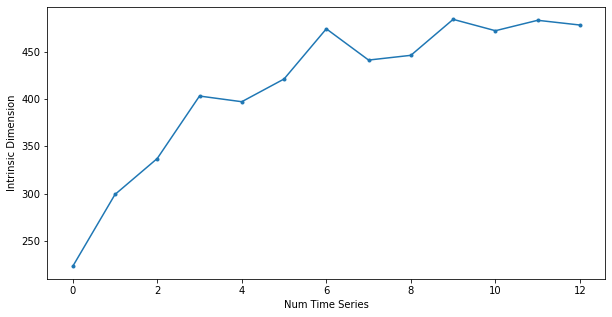

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in grassland_id], marker=".");

In [85]:
shrub_rfls = get_rfls(shrub)

%:  0.0
%:  1.7241379310344827
%:  3.4482758620689653
%:  5.172413793103448
%:  6.896551724137931
%:  8.620689655172415
%:  10.344827586206897
%:  12.068965517241379
%:  13.793103448275861
%:  15.517241379310345
%:  17.24137931034483
%:  18.96551724137931
%:  20.689655172413794
%:  22.413793103448278
%:  24.137931034482758
%:  25.862068965517242
%:  27.586206896551722
%:  29.310344827586203
%:  31.03448275862069
%:  32.758620689655174
%:  34.48275862068966
%:  36.206896551724135
%:  37.93103448275862
%:  39.6551724137931
%:  41.37931034482759
%:  43.103448275862064
%:  44.827586206896555
%:  46.55172413793103
%:  48.275862068965516
%:  50.0
%:  51.724137931034484
%:  53.44827586206896
%:  55.172413793103445
%:  56.896551724137936
%:  58.620689655172406
%:  60.3448275862069
%:  62.06896551724138
%:  63.793103448275865
%:  65.51724137931035
%:  67.24137931034483
%:  68.96551724137932
%:  70.6896551724138
%:  72.41379310344827
%:  74.13793103448276
%:  75.86206896551724
%:  77.58620689655

In [86]:
num_dates = len(shrub_rfls.keys())
shrub_dates = [create_raw_time_series(shrub_rfls, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [112]:
shrub_series = []
remove_bands = True

for dates, mean_freq in shrub_dates:
    master = None
    for d in dates:
        ds = np.array(shrub_rfls[d])
        if remove_bands:
                # ds = remove_bands_f(ds)
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    shrub_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [148]:
# run the ID 
# shrub_id = []
# for i, series in enumerate(shrub_series):
#     print("Series: ", i+1)
#     this_mat = np.array(series['data'])

#     this_noise = corrected_noise
#     for j in range(i):
#         this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
#     this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
#     instrinsic_dimension = ID()
#     _id = instrinsic_dimension(this_mat, this_n_est)
#     print("ID: ",_id['intrinsic_dimension'])
#     shrub_id.append(_id)
    
shrub_id = thread_series(shrub_series) 

Starting Series:  1
Starting Series:  2
Starting Series:  3
Starting Series:  4
Starting Series:  5
Starting Series:  6
Starting Series:  7
Starting Series:  8
Starting Series:  9
Starting Series:  10
Starting Series:  11
Starting Series:  12
Starting Series:  13
Series: 1 ID: 250
Series: 2 ID: 345
Series: 3 ID: 394
Series: 5 ID: 461
Series: 6 ID: 487
Series: 4 ID: 506
Series: 8 ID: 513
Series: 9 ID: 515
Series: 7 ID: 561
Series: 10 ID: 562
Series: 11 ID: 556
Series: 12 ID: 565
Series: 13 ID: 560


In [153]:
shrub_id_2 = [s['intrinsic_dimension'] for i, s in shrub_id]

In [10]:
shrub_id_2 = [250, 345, 394, 506, 461, 487, 561, 513, 515, 562, 556, 565, 560]

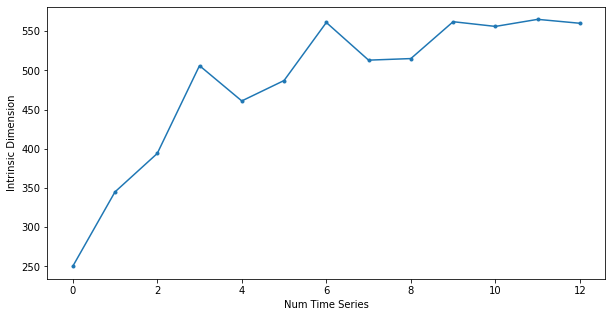

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot(shrub_id_2, marker=".");

In [88]:
tree_rfls = get_rfls(tree)

%:  0.0
%:  0.5988023952095809
%:  1.1976047904191618
%:  1.7964071856287425
%:  2.3952095808383236
%:  2.9940119760479043
%:  3.592814371257485
%:  4.191616766467066
%:  4.790419161676647
%:  5.389221556886228
%:  5.9880239520958085
%:  6.58682634730539
%:  7.18562874251497
%:  7.784431137724551
%:  8.383233532934131
%:  8.982035928143713
%:  9.580838323353294
%:  10.179640718562874
%:  10.778443113772456
%:  11.377245508982035
%:  11.976047904191617
%:  12.574850299401197
%:  13.17365269461078
%:  13.77245508982036
%:  14.37125748502994
%:  14.97005988023952
%:  15.568862275449103
%:  16.16766467065868
%:  16.766467065868262
%:  17.365269461077844
%:  17.964071856287426
%:  18.562874251497004
%:  19.16167664670659
%:  19.760479041916167
%:  20.35928143712575
%:  20.958083832335326
%:  21.55688622754491
%:  22.15568862275449
%:  22.75449101796407
%:  23.353293413173652
%:  23.952095808383234
%:  24.550898203592812
%:  25.149700598802394
%:  25.748502994011975
%:  26.34730538922156
%: 

In [89]:
num_dates = len(tree_rfls.keys())
tree_dates = [create_raw_time_series(tree_rfls, i, remove_bands=False) for i in range(num_dates)] # water bands already removed

  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-22 00:00:00 | 2022-03-27 00:00:00 | 5
2022-04-29 00:00:00 | 2022-04-27 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Difference
2022-02-24 00:00:00 | 2022-02-24 00:00:00 | 0
2022-03-16 00:00:00 | 2022-03-19 00:00:00 | 3
2022-04-12 00:00:00 | 2022-04-12 00:00:00 | 0
2022-05-03 00:00:00 | 2022-05-05 00:00:00 | 2
2022-05-29 00:00:00 | 2022-05-29 00:00:00 | 0
  Real Date  |  Desired Optimal Date  |  Differenc

In [113]:
tree_series = []
remove_bands = True

for dates, mean_freq in tree_dates:
    master = None
    for d in dates:
        ds = np.array(tree_rfls[d])
        if remove_bands:
                # ds = remove_bands_f(ds)
                ds = ds[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = ds
        else:
            master = np.concatenate([master, ds], axis=1)
    tree_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [18]:
# run the ID 
tree_id = []
for i, series in enumerate(tree_series):
    print("Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    tree_id.append(_id)

Series:  1
ID:  335
Series:  2
ID:  601
Series:  3
ID:  724
Series:  4


/home/makiper/Notebooks/pca_items/intrinsic_dimension.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  rhos[b] = np.dot(evecs1[:, b], np.dot(phi, evecs2[:, b]))/np.dot(evecs1[:, b], evecs2[:, b])


ID:  914
Series:  5
ID:  953
Series:  6
ID:  1049
Series:  7
ID:  1209
Series:  8
ID:  1204
Series:  9
ID:  1236
Series:  10
ID:  1371
Series:  11
ID:  1437
Series:  12
ID:  1450
Series:  13
ID:  1509


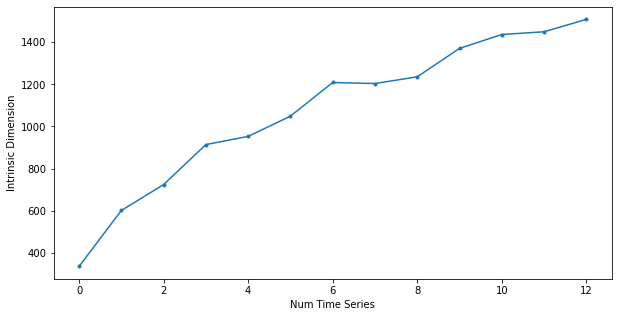

In [20]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in tree_id], marker=".");

In [114]:
parking_lot_exp = [parking_lot_series[i]['data'] for i in range(len(parking_lot_series))]
roof_top_exp = [roof_top_series[i]['data'] for i in range(len(roof_top_series))]
rock_exp = [rock_series[i]['data'] for i in range(len(rock_series))]

grassland_exp = [grassland_series[i]['data'] for i in range(len(grassland_series))]
shrub_exp = [shrub_series[i]['data'] for i in range(len(shrub_series))]
tree_exp = [tree_series[i]['data'] for i in range(len(tree_series))]

In [115]:
import pickle

with open("grassland_2.pickle", "wb") as f:
    pickle.dump(grassland_exp, f)
    
with open("shrub_2.pickle", "wb") as f_2:
    pickle.dump(shrub_exp, f_2)
    
with open("tree_2.pickle", "wb") as f_3:
    pickle.dump(tree_exp, f_3)
    
with open("parking_lot_2.pickle", "wb") as f:
    pickle.dump(parking_lot_exp, f)
    
with open("roof_top_2.pickle", "wb") as f_2:
    pickle.dump(roof_top_exp, f_2)
    
with open("rock_2.pickle", "wb") as f_3:
    pickle.dump(rock_exp, f_3)

In [13]:
# create overlay with all of the surface types

In [10]:
import pickle

In [121]:
roof_top_id

[]

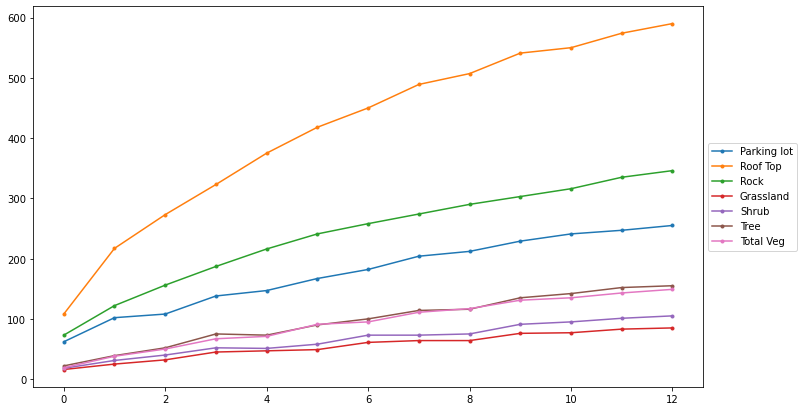

In [174]:
fig = plt.figure(figsize=(12, 7))
parking_lot_d = [62, 102, 108, 138, 147, 167, 182, 204, 212, 229, 241, 247, 255]
roof_top_d = [108, 217, 273, 323, 375, 418, 450, 489, 507, 541, 550, 574, 590]
# rock_d = [124, 245, 316, 404, 429, 492, 554, 596, 606, 655, 682, 707, 723]
rock_d = [i["intrinsic_dimension"] for i in rock_id_2]
graddland_d = [16, 25, 32, 45, 47, 49, 61, 64, 64, 76, 77, 83, 85]
shrub_d = [18, 31, 40, 52, 51, 58, 73, 73, 75, 91, 95, 101, 105]
tree_d = [22, 39, 52, 75, 73, 90, 100, 114, 116, 135, 142, 152, 155]

plt.plot(parking_lot_d, marker="."); # parking lot
plt.plot(roof_top_d, marker="."); #roof top
plt.plot(rock_d, marker="."); # rocks
plt.plot(graddland_d, marker="."); # grassland
plt.plot(shrub_d, marker="."); # shrub
plt.plot(tree_d, marker="."); # Tree
plt.plot([i["intrinsic_dimension"] for i in total_veg_id], marker=".");
plt.legend(['Parking lot', 'Roof Top', 'Rock', 'Grassland', 'Shrub', 'Tree', 'Total Veg'], loc='center left', bbox_to_anchor=(1, 0.5));

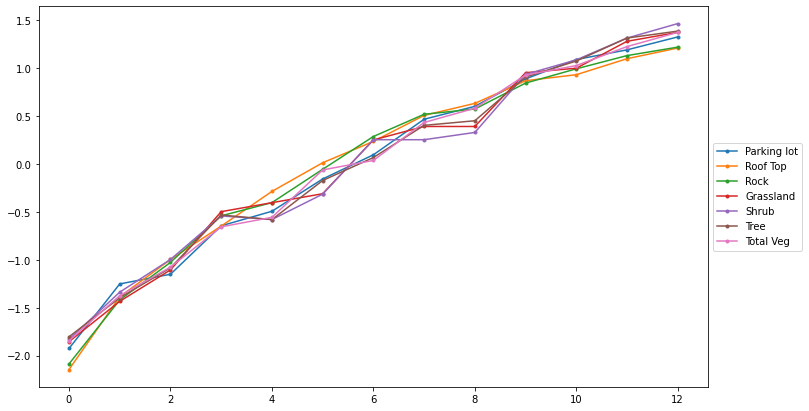

In [173]:
fig = plt.figure(figsize=(12, 7))

plt.plot([(i-np.mean(parking_lot_d))/np.std(parking_lot_d) for i in parking_lot_d], marker="."); # parking lot
plt.plot([(i-np.mean(roof_top_d))/np.std(roof_top_d) for i in roof_top_d], marker="."); #roof top
plt.plot([(i-np.mean(rock_d))/np.std(rock_d) for i in rock_d], marker="."); # rocks
plt.plot([(i-np.mean(graddland_d))/np.std(graddland_d) for i in graddland_d], marker="."); # grassland
plt.plot([(i-np.mean(shrub_d))/np.std(shrub_d) for i in shrub_d], marker="."); # shrub
plt.plot([(i-np.mean(tree_d))/np.std(tree_d) for i in tree_d], marker="."); # Tree
veg = [i["intrinsic_dimension"] for i in total_veg_id]
plt.plot([(i-np.mean(veg))/np.std(veg) for i in veg], marker=".");
plt.legend(['Parking lot', 'Roof Top', 'Rock', 'Grassland', 'Shrub', 'Tree', 'Total Veg'], loc='center left', bbox_to_anchor=(1, 0.5));

In [118]:
with open('rock_id_2.pickle', 'rb') as f:
    rock_id = pickle.load(f)
    
with open('parking_lot_id_2.pickle', 'rb') as f:
    parking_lot_id = pickle.load(f)
    
with open('roof_top_id_2.pickle', 'rb') as f:
    roof_top_id = pickle.load(f)
    
with open('shrub_id_2.pickle', 'rb') as f:
    shrub_id = pickle.load(f)
    
with open('tree_id_2.pickle', 'rb') as f:
    tree_id = pickle.load(f)
    
with open('grassland_id_2.pickle', 'rb') as f:
    grassland_id = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'rock_id_2.pickle'

In [12]:
parking_lot_data = [parking_lot_id[i]['intrinsic_dimension'] for i in range(len(parking_lot_id))]
parking_lot_data = [335, 531, 713, 878, 965, 980, 1176, 1240, 1219, 1288, 1330, 1441, 1464]
roof_top_data = [roof_top_id[i]['intrinsic_dimension'] for i in range(len(roof_top_id))]
rock_data = [rock_id[i]['intrinsic_dimension'] for i in range(len(rock_id))]
rock_data = [335, 670, 1005, 1244, 1673, 1933, 2102, 2384, 2587, 2734, 2921, 3097, 3243]

grassland_data = [grassland_id[i]['intrinsic_dimension'] for i in range(len(grassland_id))]
shrub_data = [shrub_id[i]['intrinsic_dimension'] for i in range(len(shrub_id))]
tree_data = [tree_id[i]['intrinsic_dimension'] for i in range(len(tree_id))]

In [13]:
# normalize/center
parking_lot_norm = [(i-np.mean(parking_lot_data))/np.std(parking_lot_data) for i in parking_lot_data]
roof_top_norm = [(i-np.mean(roof_top_data))/np.std(roof_top_data) for i in roof_top_data]
rock_norm = [(i-np.mean(rock_data))/np.std(rock_data) for i in rock_data]

grassland_norm = [(i-np.mean(grassland_data))/np.std(grassland_data) for i in grassland_data]
shrub_norm = [(i-np.mean(shrub_data))/np.std(shrub_data) for i in shrub_data]
tree_norm = [(i-np.mean(tree_data))/np.std(roof_top_data) for i in tree_data]

In [21]:
roof_top_norm = [(i-np.mean(roof_top_data)) for i in roof_top_data]
parking_lot_norm = [(i-np.mean(parking_lot_data)) for i in parking_lot_data]
rock_norm = [(i-np.mean(rock_data)) for i in rock_data]

grassland_norm = [(i-np.mean(grassland_data)) for i in grassland_data]
shrub_norm = [(i-np.mean(shrub_data)) for i in shrub_data]
tree_norm = [(i-np.mean(tree_data)) for i in tree_data]

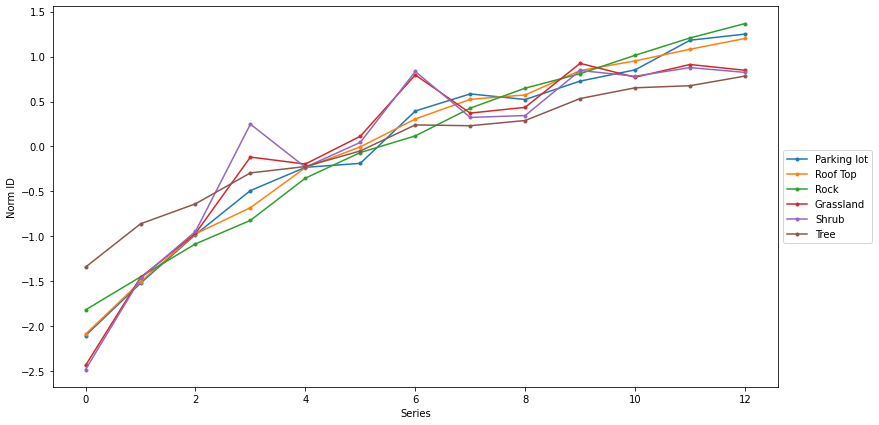

In [14]:
fig = plt.figure(figsize=(13,7))
plt.plot(parking_lot_norm, marker='.');
plt.plot(roof_top_norm, marker='.');
plt.plot(rock_norm, marker='.');
plt.plot(grassland_norm, marker='.');
plt.plot(shrub_norm, marker='.');
plt.plot(tree_norm, marker='.');

plt.xlabel("Series")
plt.ylabel("Norm ID")
plt.legend(['Parking lot', 'Roof Top', 'Rock', 'Grassland', 'Shrub', 'Tree'], loc='center left', bbox_to_anchor=(1, 0.5));

In [138]:
usable_tree_indicies = [i for i in range(tree_series[12]['data'].shape[0]) if  -9999 not in tree_series[12]['data'][i]]
usable_grassland_indicies = [i for i in range(grassland_series[12]['data'].shape[0]) if  -9999 not in grassland_series[12]['data'][i]]
usable_shrub_indicies = [i for i in range(shrub_series[12]['data'].shape[0]) if  -9999 not in shrub_series[12]['data'][i]]

total_series = []
remove_bands = True

for dates, mean_freq in tree_dates:
    master = None
    for d in dates:
        ds_tree = np.array(tree_rfls[d])[usable_tree_indicies]
        ds_grassland = np.array(grassland_rfls[d])[usable_grassland_indicies]
        ds_shrub = np.array(shrub_rfls[d])[usable_shrub_indicies]
        if remove_bands:
            # ds_tree = remove_bands_f(ds_tree)
            # ds_grassland = remove_bands_f(ds_grassland)
            # ds_shrub = remove_bands_f(ds_shrub)
            ds_tree = ds_tree[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
            ds_grassland = ds_grassland[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
            ds_shrub = ds_shrub[:,indicies[0]] # IMPORTANT REMOVE THIS WHEN NOT RUNNING ON NWE NOISE MATRIX
                
        if master is None:
            master = np.concatenate([ds_tree, ds_grassland, ds_shrub], axis=0)
        else:
            additional = np.concatenate([ds_tree, ds_grassland, ds_shrub], axis=0)
            master = np.concatenate([master, additional], axis=1)
    total_series.append({'dates':dates, 'mean_frequency':mean_freq, 'data':master})

In [139]:
total_veg_id = []
for i, series in enumerate(total_series):
    print("Series: ", i+1)
    this_mat = np.array(series['data'])

    this_noise = corrected_noise
    for j in range(i):
        this_noise = np.concatenate([this_noise, corrected_noise], axis=0)    
    this_n_est = {'noise_covariance':np.diag(this_noise), 'estimation_method': 'MultipleRegressionClassicNoiseEstimator'} 
    
    instrinsic_dimension = ID()
    _id = instrinsic_dimension(this_mat, this_n_est)
    print("ID: ",_id['intrinsic_dimension'])
    total_veg_id.append(_id)

Series:  1
ID:  19
Series:  2
ID:  38
Series:  3
ID:  50
Series:  4
ID:  67
Series:  5
ID:  71
Series:  6
ID:  91
Series:  7
ID:  95
Series:  8
ID:  111
Series:  9
ID:  117
Series:  10
ID:  131
Series:  11
ID:  135
Series:  12
ID:  143
Series:  13
ID:  149


In [29]:
total_veg_id = [{"intrinsic_dimension":i} for i in [335, 633, 772, 943, 1009, 1122, 1203, 1284, 1328, 1404, 1445, 1493, 1533]]

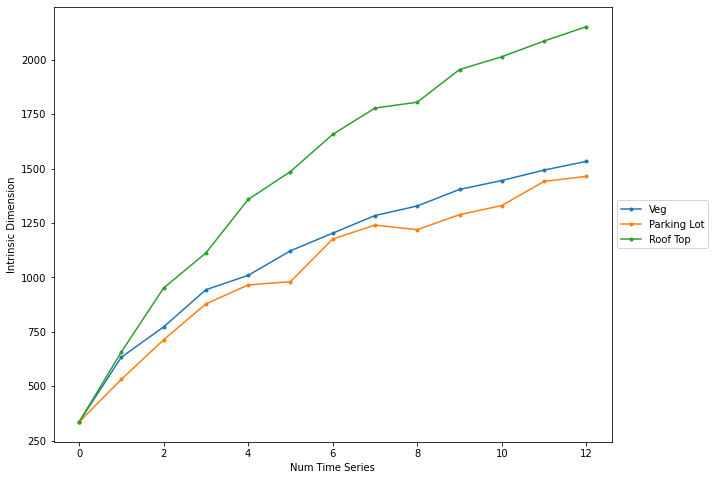

In [31]:
fig = plt.figure(figsize=(10, 8))
plt.xlabel("Num Time Series")
plt.ylabel("Intrinsic Dimension")
plt.plot([i["intrinsic_dimension"] for i in total_veg_id], marker=".");
plt.plot(parking_lot_data, marker='.');
plt.plot(roof_top_data, marker='.');
plt.legend(['Veg', 'Parking Lot', 'Roof Top'], loc='center left', bbox_to_anchor=(1, 0.5));
# plt.plot([i['data'].shape[1] for i in total_series], marker=".");